# Comparison of community detection algorithms

In [115]:
import networkx as nx
import community as community_louvain
import time
import pandas as pd
import igraph as ig
from igraph import Graph
import infomap
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

## Load edge list

In [4]:
def load_edge_list(file_path):
    edge_list = []

    with open(file_path, "r") as file:
        for line in file:
            # Extract two nodes from the line
            node1, node2 = map(int, line.strip().split())
            edge_list.append((node1, node2))

    return edge_list

## Create the graph

In [5]:
def create_graph(file_path):
    # Load edge list and create undirected graph
    edge_list = load_edge_list(file_path)
    graph = nx.Graph()
    graph.add_edges_from(edge_list)
    return graph

## Define a function that shows the stats of network

In [104]:
def print_graph_stats(graph):
    # Calculate the number of nodes
    num_nodes = nx.number_of_nodes(graph)
    print("Number of nodes:", num_nodes)

    # Calculate the number of edges
    num_edges = nx.number_of_edges(graph)
    print("Number of edges:", num_edges)

    # Calculate the network density
    density = nx.density(graph)
    print("Network density:", density)

## Define the community detection method
### Walktrap

In [73]:
def detect_communities_walktrap(graph):
    start_time = time.time()
    
    # Convert NetworkX graph to igraph graph
    ig_graph = ig.Graph.from_networkx(graph)
    
    # Run walktrap
    walktrap_results = ig_graph.community_walktrap(steps=4)
    
    # Extract community partitions from walktrap results
    communities = walktrap_results.as_clustering()

    # Running Time
    elapsed_time = time.time() - start_time
    
    # Modularity
    modularity = ig_graph.modularity(communities)
    
    return [elapsed_time, modularity]

### Infomap

In [74]:
def detect_communities_infomap(graph):
    start_time = time.time()

    # Convert NetworkX graph to igraph graph
    ig_graph = ig.Graph.from_networkx(graph)

    # Initialize the Infomap
    im = infomap.Infomap("--silent")

    # Add nodes and edges from igraph graph
    for e in ig_graph.es:
        im.add_link(int(e.source), int(e.target))

    # Run Infomap 
    im.run()

    # Extract community division
    communities = {node.node_id: node.module_id for node in im.nodes if node.is_leaf}
    
    # Running Time
    elapsed_time = time.time() - start_time

    # Modularity
    modularity = ig_graph.modularity(list(communities.values()))

    return [elapsed_time, modularity]

### Fast Greedy

In [98]:
def detect_communities_fast_greedy(graph):
    start_time = time.time()
    
    #Run greedy
    dendrogram = nx.community.greedy_modularity_communities(graph)
    communities = [set(community) for community in dendrogram]
    
    # Running Time
    elapsed_time = time.time() - start_time
    
    # Convert community assignments to a dictionary
    partition = {node: i for i, community in enumerate(communities) for node in community}

    # Modularity
    modularity = nx.algorithms.community.modularity(graph, communities)
    
    return [elapsed_time, modularity]

### Louvain

In [76]:
def detect_communities_louvain(graph):
    start_time = time.time()
    
    # Run louvain
    partition = community_louvain.best_partition(graph)
    
    # Running TIme
    elapsed_time = time.time() - start_time
    
    # Modularity
    modularity = community_louvain.modularity(partition, graph)
    
    return [elapsed_time, modularity]

### Label Propagation

In [65]:
def detect_communities_label_propagation(graph):
    start_time = time.time()
    
    # Run Label Propagation 
    communities = nx.algorithms.community.label_propagation_communities(graph)
        
    # Running TIme
    elapsed_time = time.time() - start_time
    
    # Convert community assignments to a dictionary
    community_dict = {node: i for i, community in enumerate(communities) for node in community}
    
    # Modularity
    modularity = nx.algorithms.community.modularity(graph, communities)


    return [elapsed_time, modularity]

### Label Propagation (for improving details)

In [12]:

def label_propagation(graph, max_iter=100):
    # Initialize label
    for node in graph.nodes():
        graph.nodes[node]['label'] = node

    # label propagation
    for _ in range(max_iter):
        nodes = list(graph.nodes())
        random.shuffle(nodes) # Disrupt the order of nodes, making the update process random
        for node in nodes:
            labels = {}

            # Count the labels of neighbor nodes
            for neighbor in graph.neighbors(node):
                label = graph.nodes[neighbor]['label']
                if label not in labels:
                    labels[label] = 0
                labels[label] += 1

            # Select the label with the most occurrences
            max_label, max_count = None, 0
            for label, count in labels.items():
                if count > max_count:
                    max_label, max_count = label, count

            graph.nodes[node]['label'] = max_label

    # Extract the community structure
    communities = {}
    for node, data in graph.nodes(data=True):
        label = data['label']
        if label not in communities:
            communities[label] = []
        communities[label].append(node)

    modularity_score = nx.algorithms.community.modularity(G, communities.values())

## Main function. 
Run the detection algorithms one by one and store the results in a dataframe.

In [99]:
def detection(graph):
    df = pd.DataFrame(columns=["Running Time", "Modularity"], index=["fast greedy", "infomap", "walktrap", "louvain", "label propagation"])

    df.loc["fast greedy"] = detect_communities_fast_greedy(graph)
    df.loc["infomap"] = detect_communities_infomap(graph)
    df.loc["walktrap"] = detect_communities_walktrap(graph)
    df.loc["louvain"] = detect_communities_louvain(graph)
    df.loc["label propagation"] = detect_communities_label_propagation(graph)
    return df

## Load the three networks

In [100]:
karate_graph = nx.karate_club_graph()
facebook = create_graph("facebook_combined.txt")
gplus = create_graph("gplus_combined.txt")

## Print the stats of network

In [112]:
facebook = create_graph("facebook_combined.txt")
print_graph_stats(facebook)

Number of nodes: 4039
Number of edges: 88234
Network density: 0.010819963503439287


## Run the detection algorithms and check the result

In [108]:
df_karate = detection(karate_graph)
df_facebook = detection(facebook)

In [109]:
df_karate

,Running Time,Modularity
fast greedy,0.013947,0.410965
infomap,0.003587,0.14193
walktrap,0.000733,0.353222
louvain,0.003977,0.443854
label propagation,0.000678,0.309486


## In addition, can also test the performance of algorithms separately
- When running algorithms on a large data set, it may be necessary to test the remaining algorithms separately due to the need to exclude some algorithms that take too long to run and consume too much resources.

In [18]:
detect_communities_infomap(gplus)

[52.604403018951416, 0.07267492183834053]

In [15]:
detect_communities_louvain(gplus)

[425.338210105896, 0.4773843919440237]

In [17]:
detect_communities_label_propagation(gplus)

[1426.6071553230286, 0.4350889132095334]

Here we manually set the value of df_google

In [19]:
df_google = pd.DataFrame(columns=["Running Time", "Modularity"], index=["fast greedy", "infomap", "walktrap", "louvain", "label propagation"])

df_google.loc["fast greedy"] = [None, None]
df_google.loc["infomap"] = detect_communities_infomap(df_google)
df_google.loc["walktrap"] = [None, None]
df_google.loc["louvain"] = detect_communities_louvain(df_google)
df_google.loc["label propagation"] = detect_communities_label_propagation(df_google)

## Draw the figure

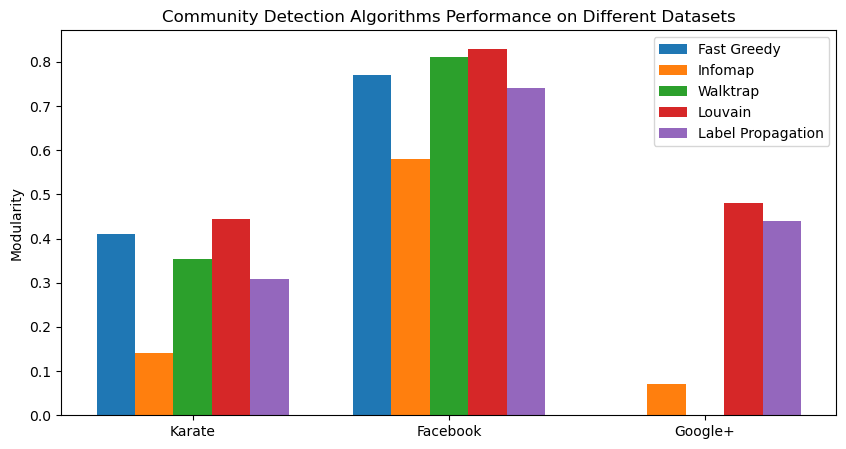

In [114]:
# Data
algorithms = ['Fast Greedy', 'Infomap', 'Walktrap', 'Louvain', 'Label Propagation']
dataset_labels = ['Karate', 'Facebook', 'Google+']
modularity_values = [
    df_karate['Modularity'],
    df_facebook['Modularity'],
    df_google['Modularity'],
]

# Set up the plot
bar_width = 0.15
fig, ax = plt.subplots(figsize=(10, 5))

# Create bar plots for each algorithm
for i, algorithm in enumerate(algorithms):
    x = np.arange(len(dataset_labels)) + i * bar_width
    y = [modularity_values[j][i] if modularity_values[j][i] is not None else 0 for j in range(len(dataset_labels))]
    ax.bar(x, y, width=bar_width, label=algorithm)

# Customize the plot
ax.set_ylabel('Modularity')
ax.set_title('Community Detection Algorithms Performance on Different Datasets')
ax.set_xticks(np.arange(len(dataset_labels)) + bar_width * (len(algorithms) - 1) / 2)
ax.set_xticklabels(dataset_labels)
ax.legend()

# Display the plot
plt.show()